In [47]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations,combinations

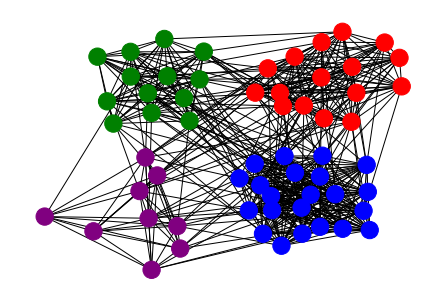

In [48]:
def generate_SBM(n,connection_matrix,edge_possibility,class_possibility):
    """This creates a random graph based on:
        n : how many node we have
        connection_matrix : the likelihood of a node in cluster i connecting to a node in cluster j
        edge_possibility : the likelihood of an edge existing between two nodes
        class_possibility : the likelihood of belonging to any given class"""
    num_clusters = len(class_possibility)
    cluster_assignments = np.sort(np.random.choice(np.arange(num_clusters),p=class_possibility,size=n))
    cluster_indices = [cluster_assignments == a for a in range(num_clusters)]
    cluster_assignments = np.expand_dims(cluster_assignments,1)
    #clusters = cluster_assignments == cluster_assignments.T
    probabilities = np.random.random((n,n))
    adj = np.zeros((n,n))
    for i in range(num_clusters):

        for j in range(num_clusters):
            mask = np.zeros((n,n),dtype=bool)
            imask = np.zeros((n,n))
            imask[cluster_indices[i]] = ~mask[cluster_indices[i]]
            if(len(cluster_indices[i]) !=0 and len(cluster_indices[j]) != 0):
                jmask = np.zeros((n,n))
                jmask[:,cluster_indices[j]] =  ~mask[:,cluster_indices[j]]
                total_mask = jmask*imask
                probs = probabilities

                probs = probs < (connection_matrix[i,j]*edge_possibility)
                #print(probs)
                probs = (total_mask*1)*probs
                #print(probs)
                adj += probs
    tri = np.tri((n),k=-1)
    adj = adj* tri
    adj += adj.T
    #print(cluster_assignments)
    return adj,cluster_assignments
    

    
adj,cluster_assignments = generate_SBM(60,np.array([[1,.1,.1,.1],[.1,1,.1,.1],[.1,.1,1,.1],[.1,.1,.1,1]]),1,[.25,.25,.25,.25])
g = nx.from_numpy_matrix(adj)
pos = []
color_map = []
for i in range(60):
    if(cluster_assignments[i] == 0):
        pos.append(((0+np.random.random(1)-.5)/2,(0+np.random.random(1)-.5)/2))
        color_map.append("blue")
    elif(cluster_assignments[i] == 1):
        pos.append((.5,.25))
        color_map.append("red")
    elif(cluster_assignments[i] == 2):
        pos.append((.25,.5))
        color_map.append("green")
    else:
        color_map.append("purple")
nx.draw_spring(g,node_color=color_map)
plt.show()



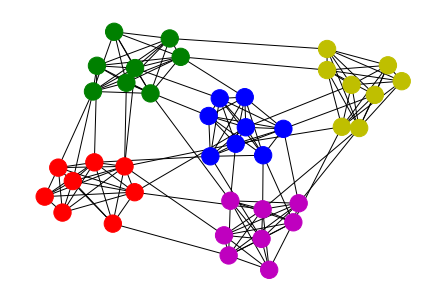

In [49]:
def generate_SSBM(n,c,p_intra,p_inter):
    """This is similar to the above SBM but in this case it is symmetric"""
    # assign a community to each node
    community = np.repeat(list(range(c)),np.ceil(n/c))
    
    #np.repeat(list to iterate over, how many times to repeat an item)

    #make sure community has size n
    community = community[0:n]
    communities = community.copy()
    # just in case repeat repeated too many

    # make it a collumn vector
    community = np.expand_dims(community,1)

    # generate a boolean matrix indicating whether 
    # two nodes share a community
    # this is a smart way to generate a section graph
    intra = community == community.T
    inter = community != community.T# we can also use np.logical not

    random = np.random.random((n,n))
    tri = np.tri(n,k=-1).astype(bool)

    intergraph = (random < p_intra) * intra * tri# this creates a matrix that only has trues where
                                                # random< p_intra, they are in intra, and along half the matrix
                                                # (if it were the whole matrix it would be double the edges we want)
    intragraph = (random < p_inter) * inter * tri# same thing here
    graph = np.logical_or(intergraph,intragraph)
    graph = graph*1# this converts it to a int tensor
    graph += graph.T
    return graph,communities
adj,communities = generate_SSBM(40,5,.9,.05)
g = nx.from_numpy_matrix(adj)
colors = np.ones((40),dtype=str)
colors[np.where(communities == 0)] = "green"
colors[np.where(communities == 1)] = "blue"
colors[np.where(communities == 2)] = "red"
colors[np.where(communities == 3)] = "m"
colors[np.where(communities == 4)] = "yellow"
nx.draw_spring(g,node_color = colors)
    

The following code implements the algorithm outlined in the cSBM paper

\begin{equation}
  \mathbb{P}(A_{ij}^{G} = 1)=
  \begin{cases}
    c_{in}/n, & \text{if both i and j are in the same cluster}\ \\
    c_{out}/n, & \text{otherwise}\
  \end{cases}
\end{equation}
\begin{equation}
b_{i}=\sqrt{\frac{\mu}{n}}v_{i}u+\frac{Z_i}{\sqrt{p}}
\end{equation}
\begin{equation}
c_{in} = d+\lambda \sqrt{d}, c_{out}=d-\lambda \sqrt{d}
\end{equation}
u is a normal random vector drawn before everything else is computed, $u\in \mathbb{R}^{p}$<br>
Z is a normal random matrix, likewise drawn before anything else is computed, $Z \in \mathbb{R}^{n\times p}$<br>
v is also a vector that encodes the partitioning of the clusters, $v \in {\{0,1\}}^{n}$<br>
Something key to observe is a specific quantity $\phi$
\begin{equation}
\xi = n/p
\end{equation}
\begin{equation}
\phi = \arctan{(\frac{\lambda \sqrt{\xi}}{\mu})} \times 2/\pi
\end{equation}
if $\phi = 0$ then the graph structure is entirely uninformative with the features more informative<br>
if $\phi > 0$ then the graph is more homophilic, with $\phi < 0$ indicating it is more heterophilic<br>
if $|\phi| = 1$ then the graph stucture is entirely informative and the features are uninformative

In [67]:
def generate_perms(num_classes,num_feat):
    assert num_classes <= num_feat
    dims = np.ceil(np.log2(num_classes))+1
    vecs = []
    vec1 = np.ones(num_feat)
    vecs.append(vec1.copy())
    vec1[-1] = -1
    vec1[-2] = -1
    perms = list(set(permutations(vec1)))
    #print(perms)
    for i in perms:
        vecs.append(i)
    #print(vecs)
    return np.array(vecs[:num_classes])

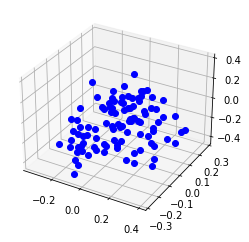

In [73]:
def generate_cSBM(d,lamb,mu,num_features,num_nodes,num_classes):
    c_in = d+lamb*np.sqrt(d) # c_in/c_out as described in the equations
    c_out = d-lamb*np.sqrt(d) 
    p_in = c_in/num_nodes # compiles these to pass into the SSBM
    p_out = c_out/num_nodes
    
    adj, communities = generate_SSBM(num_nodes,num_classes,p_in,p_out) # obtains the graph structure
    u = np.random.normal(0,1/num_features,(num_features)) # obtains the random normal vector u
    Z = np.random.normal(0,.2,(num_nodes,num_features)) # obtains the random noise vector i presume
    v = communities # puts the groups into a format for the equations
    
    perms = generate_perms(num_classes,num_features)
    #print(communities)
    #print(perms)
    b = np.zeros((num_nodes,num_features))
    for i in range(num_nodes):
        b[i] = np.sqrt(mu/num_nodes)*(np.diag(perms[v[i]])@u) + Z[i]/np.sqrt(num_features)
    return adj,b,communities



adj,b,labels = generate_cSBM(1,.5,250,3,100,3)
fig = plt.figure()
ax = plt.axes(projection = "3d")
ax.plot3D(b[:,0],b[:,1],b[:,2],"bo")
#plt.plot(b[:,0],b[:,1],"bo")

# GCN
The following code implements the cSBM for two classes to run a GCN on 

epoch: 0 training_loss: 0.6931669116020203 training_acc: 0.44 val_loss: 0.6945585608482361 val_acc: 0.46
epoch: 5 training_loss: 0.6918903589248657 training_acc: 0.5 val_loss: 0.6909092664718628 val_acc: 0.5
epoch: 10 training_loss: 0.6914784908294678 training_acc: 0.64 val_loss: 0.6941992044448853 val_acc: 0.42
epoch: 15 training_loss: 0.685802698135376 training_acc: 0.84 val_loss: 0.6868672370910645 val_acc: 0.74
epoch: 20 training_loss: 0.6894822120666504 training_acc: 0.68 val_loss: 0.6884002089500427 val_acc: 0.68
epoch: 25 training_loss: 0.6895469427108765 training_acc: 0.7 val_loss: 0.6911530494689941 val_acc: 0.56
epoch: 30 training_loss: 0.6824151873588562 training_acc: 0.84 val_loss: 0.6846141219139099 val_acc: 0.74
epoch: 35 training_loss: 0.6767070889472961 training_acc: 0.86 val_loss: 0.6795719265937805 val_acc: 0.74
epoch: 40 training_loss: 0.6835503578186035 training_acc: 0.7 val_loss: 0.6877462267875671 val_acc: 0.62
epoch: 45 training_loss: 0.6820592284202576 training_

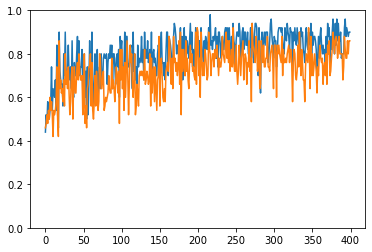

In [18]:
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
class GCN(torch.nn.Module):# this is the torch geometric implementation of our GCN model like before, it
    # is a lot simpler to implement and way customizeable
    def __init__(self, in_feat, hid_feat, out_feat):
        super().__init__()
        self.conv1 = GCNConv(in_feat, hid_feat)
        self.conv2 = GCNConv(hid_feat, out_feat)
        self.activation = nn.ReLU()
        #self.dropout = nn.Dropout(p=.4)

    def forward(self, x,edge_index):
        x = self.activation(self.conv1(x, edge_index))
        x = F.dropout(x, training= self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x,dim=1)

def adj_to_list(a):
    adjList =[[],[]]
    for i in range(len(a)):
        for j in range(len(a[i])):
            if a[i][j]== 1:
                adjList[0].append(i)
                adjList[1].append(j)
    return adjList

def accuracy(preds,mask):# obtains the accuracy of the model
    correct = (preds[mask] == labels[mask]).sum()
    acc = int(correct)/int(mask.sum())
    return acc

# these are the hyperparameters to generate the graph/features, still unsure how tweaking them would change the graph
d=10 # this is the average degree
lamb = -4 # difference in edge_densities, 0 indicates only node features are informative lamb>0 means more intra edges vs inter edges(homophily)
# lamb < 0 means less intra edges vs inter edges(heterophily)
mu = 0# difference between the means of the two classes, increasing this means increasing difference between class features
num_nodes = 100
num_features = 3
num_classes=3

adj, b, labels = generate_cSBM(d,lamb,mu,num_features,num_nodes)
edge_list = adj_to_list(adj)

# our hyperparameter for our hidden model
hidden_layers = 2
lr = .01
epochs = 400

# sets up model/optimizer
model = GCN(num_features,hidden_layers,num_classes)
optimizer = torch.optim.Adam(params=model.parameters(),lr = lr)

# creates some masks so we have stuff for training and validation
train_mask = torch.tensor([False,True]).repeat(num_nodes//2)
val_mask = ~train_mask

# turns all of our tensors into the desired format
edge_list = torch.Tensor(edge_list).to(torch.long)
b = torch.Tensor(b)
labels = torch.Tensor(labels).to(torch.long)

model.train()# tells our model we are about to train
losses = []
accs = []
for epoch in range(epochs):# runs through all the data 200 times
    optimizer.zero_grad()
    out = model(b,edge_list)

    train_loss = F.nll_loss(out[train_mask], labels[train_mask])
    train_acc = accuracy(out.max(1)[1], train_mask)

    val_loss = F.nll_loss(out[val_mask], labels[val_mask])
    val_acc = accuracy(out.max(1)[1], val_mask)
    losses.append([train_loss.item(),val_loss.item()])
    accs.append([train_acc,val_acc])
    if(epoch %5 == 0):
        print("epoch: {} training_loss: {} training_acc: {} val_loss: {} val_acc: {}".format(epoch,train_loss,train_acc,val_loss, val_acc))
        
    train_loss.backward()
    optimizer.step()

losses = np.array(losses)
accs = np.array(accs)
plt.plot(accs[:,0])
plt.plot(accs[:,1])
plt.ylim(0,1)

model.eval()
out = model(b,edge_list)
test_acc = accuracy(out.max(1)[1],torch.ones(num_nodes).to(torch.bool))
print(test_acc)